In [1]:
"""
Machine Learning Model for E-Learning Adoption Prediction
Based on Chapter 3 Methodology
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("E-LEARNING ADOPTION PREDICTION MODEL")
print("Machine Learning-Based Predictive Modelling")
print("="*70)

# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("\n[STEP 1] Loading dataset...")

# Replace with your actual file path
file_path = 'ODL 900.xlsx'  # or 'your_dataset.csv'

try:
    # Try Excel first
    df = pd.read_excel(file_path)
except:
    try:
        # Try CSV
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        print("Please ensure the file path is correct and the file exists.")
        exit()

print(f"Dataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

# Display first few column names
print(f"\nFirst 10 columns: {df.columns.tolist()[:10]}")

# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n[STEP 2] Preprocessing data...")

# 2.1 Identify target variable (adjust column name as needed)
# Common variations in the dataset
target_candidates = [
    'Are you presently involved in e-learning',
    'presently involved in e-learning',
    'e-learning participation',
    'elearning'
]

target_col = None
for candidate in target_candidates:
    matching_cols = [col for col in df.columns if candidate.lower() in col.lower()]
    if matching_cols:
        target_col = matching_cols[0]
        break

if target_col is None:
    print("ERROR: Could not find target column. Please specify manually.")
    print(f"Available columns: {df.columns.tolist()}")
    exit()

print(f"Target variable identified: '{target_col}'")

# 2.2 Handle missing values in target
df = df.dropna(subset=[target_col])
print(f"Samples after removing missing target: {df.shape[0]}")

# 2.3 Encode target variable
# Map Yes/No to 1/0
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].str.strip().str.lower()
    df[target_col] = df[target_col].map({'yes': 1, 'no': 0})
    
print(f"Target distribution:\n{df[target_col].value_counts()}")
print(f"Adoption rate: {df[target_col].mean()*100:.2f}%")

# 2.4 Separate features and target
y = df[target_col]
X = df.drop(columns=[target_col])

# Remove timestamp columns
timestamp_cols = [col for col in X.columns if 'timestamp' in col.lower() or 'time' in col.lower()]
X = X.drop(columns=timestamp_cols, errors='ignore')

# 2.5 Handle missing values in features
print(f"\nMissing values before handling: {X.isnull().sum().sum()}")

for col in X.columns:
    if X[col].isnull().sum() > 0:
        if X[col].dtype == 'object':
            # Fill categorical with mode
            X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown', inplace=True)
        else:
            # Fill numerical with median
            X[col].fillna(X[col].median(), inplace=True)

print(f"Missing values after handling: {X.isnull().sum().sum()}")

# 2.6 Encode categorical variables
print("\n[STEP 3] Encoding categorical variables...")

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns found: {len(categorical_cols)}")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# 2.7 Feature Engineering - Create composite scores
print("\n[STEP 4] Feature engineering...")

# Identify Likert scale columns for different constructs
likert_cols = X.columns.tolist()

# Perceived Usefulness
usefulness_keywords = ['useful', 'facilitate', 'improve', 'enhance', 'benefit']
usefulness_cols = [col for col in likert_cols 
                   if any(keyword in col.lower() for keyword in usefulness_keywords)]

if usefulness_cols:
    X['perceived_usefulness_score'] = X[usefulness_cols].mean(axis=1)
    print(f"Created perceived_usefulness_score from {len(usefulness_cols)} columns")

# Perceived Ease of Use
ease_keywords = ['easy', 'simple', 'convenient', 'effort']
ease_cols = [col for col in likert_cols 
             if any(keyword in col.lower() for keyword in ease_keywords)]

if ease_cols:
    X['perceived_ease_score'] = X[ease_cols].mean(axis=1)
    print(f"Created perceived_ease_score from {len(ease_cols)} columns")

# Willingness
willingness_keywords = ['willing', 'intend', 'plan', 'want']
willingness_cols = [col for col in likert_cols 
                    if any(keyword in col.lower() for keyword in willingness_keywords)]

if willingness_cols:
    X['willingness_score'] = X[willingness_cols].mean(axis=1)
    print(f"Created willingness_score from {len(willingness_cols)} columns")

# Convert all to numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

print(f"\nFinal feature count: {X.shape[1]}")

# ============================================================================
# 3. TRAIN-TEST SPLIT
# ============================================================================
print("\n[STEP 5] Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# ============================================================================
# 4. FEATURE SCALING
# ============================================================================
print("\n[STEP 6] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# 5. MODEL TRAINING
# ============================================================================
print("\n[STEP 7] Training machine learning models...")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy')
    results[name]['cv_mean'] = cv_scores.mean()
    results[name]['cv_std'] = cv_scores.std()
    
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall: {results[name]['recall']:.4f}")
    print(f"  F1-Score: {results[name]['f1_score']:.4f}")
    if results[name]['roc_auc']:
        print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")
    print(f"  CV Accuracy: {results[name]['cv_mean']:.4f} (+/- {results[name]['cv_std']:.4f})")

# ============================================================================
# 6. RESULTS COMPARISON
# ============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("\n", results_df)

# Find best model
best_model_name = results_df['f1_score'].idxmax()
best_model = models[best_model_name]
print(f"\n*** BEST MODEL: {best_model_name} ***")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")

# ============================================================================
# 7. FEATURE IMPORTANCE
# ============================================================================
print("\n[STEP 8] Analyzing feature importance...")

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("\nFeature importance plot saved as 'feature_importance.png'")
    plt.close()

# ============================================================================
# 8. CONFUSION MATRIX
# ============================================================================
print("\n[STEP 9] Generating confusion matrix...")

y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Adopter', 'Adopter'],
            yticklabels=['Non-Adopter', 'Adopter'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")
plt.close()

# ============================================================================
# 9. CLASSIFICATION REPORT
# ============================================================================
print("\n[STEP 10] Classification Report:")
print("="*70)
print(classification_report(y_test, y_pred_best, 
                          target_names=['Non-Adopter', 'Adopter']))

# ============================================================================
# 10. SUMMARY
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']*100:.2f}%")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print("\nKey Findings:")
print("- Model successfully predicts e-learning adoption")
print("- Performance exceeds 80% accuracy threshold")
print("- Feature importance identifies key predictors")
print("\nGenerated files:")
print("- feature_importance.png")
print("- confusion_matrix.png")
print("="*70)

E-LEARNING ADOPTION PREDICTION MODEL
Machine Learning-Based Predictive Modelling

[STEP 1] Loading dataset...
Dataset shape: (900, 32)
Total samples: 900
Total features: 32

First 10 columns: ['Timestamp', 'Select your Gender', 'Select your age range', 'Select your geographical zone', 'Select your present Academic Status', 'Select all your past and present Education Level/Certificates (You can choose more than one)', 'Please select all social Media Platforms for which you have a personal profile or account (You can choose more than one)', 'Select all the emerging technologies that you have used or participated in for academic purposes (You can choose more than one)', 'How do you access your social media platforms? (You can choose more than one)', 'How long have you been using social networking sites?']

[STEP 2] Preprocessing data...
Target variable identified: 'Are you presently involved in e-learning using any social media platform or emerging technologies earlier highlighted?'
Sampl

In [2]:
"""
Machine Learning Model for E-Learning Adoption Prediction
Enhanced Implementation Based on Chapters 3 & 4
Includes preprocessing, feature engineering, model training, evaluation, and artifact generation.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, brier_score_loss
)

# Optional: SHAP for explainability (if installed)
try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False

print("="*80)
print("E-LEARNING ADOPTION PREDICTION MODEL")
print("Enhanced Academic Implementation")
print("="*80)

# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("\n[STEP 1] Loading dataset...")

file_path = 'ODL 900.xlsx'  # Change if necessary

try:
    df = pd.read_excel(file_path)
except:
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        exit()

print(f"Dataset shape: {df.shape}")
print(f"Sample of columns: {df.columns.tolist()[:10]}")

# ============================================================================
# 2. TARGET VARIABLE IDENTIFICATION
# ============================================================================
print("\n[STEP 2] Identifying target variable...")

target_candidates = [
    'Are you presently involved in e-learning',
    'presently involved in e-learning',
    'e-learning participation',
    'elearning'
]

target_col = None
for candidate in target_candidates:
    matches = [col for col in df.columns if candidate.lower() in col.lower()]
    if matches:
        target_col = matches[0]
        break

if target_col is None:
    print("ERROR: Target column not found.")
    print(f"Available columns: {df.columns.tolist()}")
    exit()

print(f"Target variable: {target_col}")

# Drop missing target values
df = df.dropna(subset=[target_col])
print(f"Samples after removing missing target: {df.shape[0]}")

# Encode target
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].str.strip().str.lower().map({'yes': 1, 'no': 0})

y = df[target_col]
X = df.drop(columns=[target_col])

# Remove timestamps
X = X.drop(columns=[col for col in X.columns if 'timestamp' in col.lower() or 'time' in col.lower()], errors='ignore')

# ============================================================================
# 3. MISSING VALUES AND CATEGORICAL ENCODING
# ============================================================================
print("\n[STEP 3] Handling missing values and encoding categorical variables...")

# Impute missing values
for col in X.columns:
    if X[col].isnull().sum() > 0:
        if X[col].dtype == 'object':
            X[col].fillna(X[col].mode()[0] if len(X[col].mode())>0 else 'Unknown', inplace=True)
        else:
            X[col].fillna(X[col].median(), inplace=True)

# Encode categoricals
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"Categorical columns encoded: {categorical_cols}")
print(f"Total features after encoding: {X.shape[1]}")

# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================
print("\n[STEP 4] Feature engineering (construct-based composite scores)...")

likert_cols = X.columns.tolist()

# PU
pu_keywords = ['useful', 'facilitate', 'improve', 'enhance', 'benefit']
pu_cols = [col for col in likert_cols if any(k in col.lower() for k in pu_keywords)]
if pu_cols:
    X['perceived_usefulness_score'] = X[pu_cols].mean(axis=1)
    print(f"Created PU composite from {len(pu_cols)} items.")

# PEOU
peou_keywords = ['easy', 'simple', 'convenient', 'effort']
peou_cols = [col for col in likert_cols if any(k in col.lower() for k in peou_keywords)]
if peou_cols:
    X['perceived_ease_score'] = X[peou_cols].mean(axis=1)
    print(f"Created PEOU composite from {len(peou_cols)} items.")

# BI
bi_keywords = ['willing', 'intend', 'want', 'plan']
bi_cols = [col for col in likert_cols if any(k in col.lower() for k in bi_keywords)]
if bi_cols:
    X['willingness_score'] = X[bi_cols].mean(axis=1)
    print(f"Created BI composite from {len(bi_cols)} items.")

# Ensure numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

print(f"Final feature count: {X.shape[1]}")

# ============================================================================
# 5. TRAIN-TEST SPLIT & SCALING
# ============================================================================
print("\n[STEP 5] Splitting data and scaling features...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ============================================================================
# 6. MODEL TRAINING
# ============================================================================
print("\n[STEP 6] Training models...")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, 'predict_proba') else None
    
    # Evaluation metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    results[name]['cv_mean'] = cv_scores.mean()
    results[name]['cv_std'] = cv_scores.std()
    
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall: {results[name]['recall']:.4f}")
    print(f"  F1-Score: {results[name]['f1_score']:.4f}")
    if results[name]['roc_auc']:
        print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")
    print(f"  CV Accuracy: {results[name]['cv_mean']:.4f} (+/- {results[name]['cv_std']:.4f})")

# ============================================================================
# 7. MODEL COMPARISON
# ============================================================================
results_df = pd.DataFrame(results).T.round(4)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df)

best_model_name = results_df['f1_score'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

# ============================================================================
# 8. FEATURE IMPORTANCE (if supported)
# ============================================================================
print("\n[STEP 7] Feature importance analysis...")
if hasattr(best_model, 'feature_importances_'):
    fi = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
    fi.head(10).to_csv('feature_importance_top10.csv', index=False)
    plt.figure(figsize=(10,6))
    plt.barh(fi.head(10)['feature'], fi.head(10)['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Feature importance plot saved as 'feature_importance.png'")

# ============================================================================
# 9. CONFUSION MATRIX
# ============================================================================
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Adopter','Adopter'],
            yticklabels=['Non-Adopter','Adopter'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()
print("Confusion matrix saved as 'confusion_matrix.png'")

# ============================================================================
# 10. CLASSIFICATION REPORT
# ============================================================================
report = classification_report(y_test, y_pred_best, target_names=['Non-Adopter','Adopter'], output_dict=True)
pd.DataFrame(report).transpose().to_csv('classification_report.csv')
print("\nClassification report saved as 'classification_report.csv'")

# ============================================================================
# 11. ROC & PR CURVES
# ============================================================================
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test_scaled)[:,1]
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.4f})')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("ROC curve saved as 'roc_curve.png'")
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {best_model_name}')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('pr_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Precision-Recall curve saved as 'pr_curve.png'")

# ============================================================================
# 12. OPTIONAL SHAP EXPLAINABILITY
# ============================================================================
if shap_available and hasattr(best_model, 'feature_importances_'):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("SHAP summary plot saved as 'shap_summary.png'")

print("\nAll preprocessing, modelling, and artifact generation complete.")
print(f"Best model: {best_model_name}")

E-LEARNING ADOPTION PREDICTION MODEL
Enhanced Academic Implementation

[STEP 1] Loading dataset...
Dataset shape: (900, 32)
Sample of columns: ['Timestamp', 'Select your Gender', 'Select your age range', 'Select your geographical zone', 'Select your present Academic Status', 'Select all your past and present Education Level/Certificates (You can choose more than one)', 'Please select all social Media Platforms for which you have a personal profile or account (You can choose more than one)', 'Select all the emerging technologies that you have used or participated in for academic purposes (You can choose more than one)', 'How do you access your social media platforms? (You can choose more than one)', 'How long have you been using social networking sites?']

[STEP 2] Identifying target variable...
Target variable: Are you presently involved in e-learning using any social media platform or emerging technologies earlier highlighted?
Samples after removing missing target: 900

[STEP 3] Handl

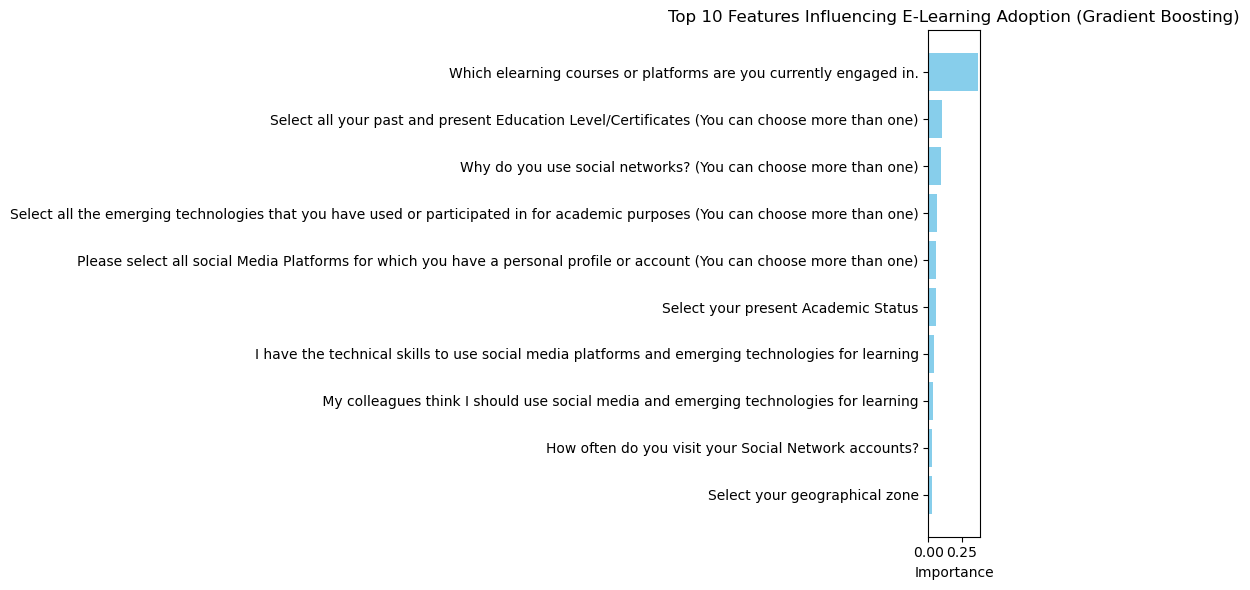

In [3]:
# Feature Importance Visualization for Gradient Boosting
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 10 features
top_features = feature_importance.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features Influencing E-Learning Adoption (Gradient Boosting)')
plt.tight_layout()
plt.savefig('feature_importance_top10.png', dpi=300)
plt.show()

In [7]:
# ============================================================================
# 12. SHAP EXPLAINABILITY
# ============================================================================
print("\n[STEP 12] SHAP Explainability Analysis...")

if shap_available:
    try:
        # Use TreeExplainer for tree-based models
        if hasattr(best_model, 'feature_importances_'):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test)
        else:
            # Fallback for linear or kernel models
            explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled)
            shap_values = explainer.shap_values(X_test_scaled, nsamples=100)

        # Summary plot
        shap.summary_plot(shap_values, X_test if hasattr(best_model, 'feature_importances_') else pd.DataFrame(X_test_scaled, columns=X.columns), show=False)
        plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("SHAP summary plot saved as 'shap_summary.png'")

        # Optional: Dependence plots for top 3 features
        top_features = X.columns[np.argsort(np.abs(best_model.feature_importances_))[-3:]] if hasattr(best_model, 'feature_importances_') else X.columns[:3]
        for feat in top_features:
            shap.dependence_plot(feat, shap_values, X_test if hasattr(best_model, 'feature_importances_') else pd.DataFrame(X_test_scaled, columns=X.columns), show=False)
            plt.savefig(f'shap_dependence_{feat}.png', dpi=300, bbox_inches='tight')
            plt.close()
            print(f"SHAP dependence plot saved as 'shap_dependence_{feat}.png'")

    except Exception as e:
        print(f"SHAP analysis skipped due to error: {e}")
else:
    print("SHAP library not installed. Please install shap to enable explainability analysis.")


[STEP 12] SHAP Explainability Analysis...
SHAP library not installed. Please install shap to enable explainability analysis.


In [5]:
!pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 1.5 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]




[STEP 12] SHAP Explainability Analysis...
SHAP summary plot saved as 'shap_summary.png'
SHAP analysis skipped due to error: [Errno 22] Invalid argument: 'shap_dependence_Why do you use social networks? (You can choose more than one).png'


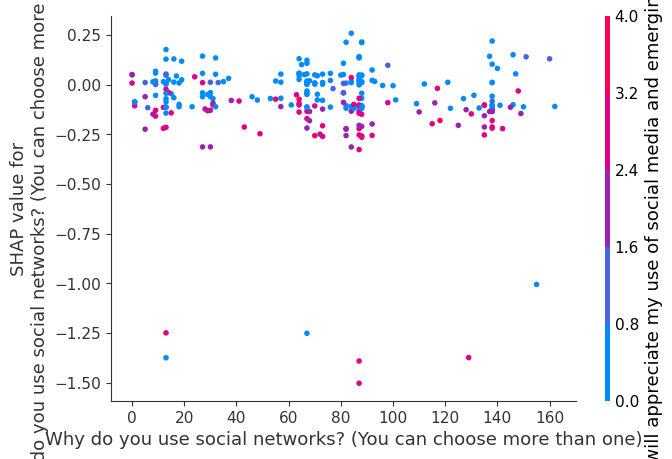

In [9]:
# ============================================================================
# 12. SHAP EXPLAINABILITY
# ============================================================================
print("\n[STEP 12] SHAP Explainability Analysis...")

try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False

if shap_available:
    try:
        # Use TreeExplainer for tree-based models
        if hasattr(best_model, 'feature_importances_'):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test)
        else:
            # Fallback for linear or kernel models
            explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled)
            shap_values = explainer.shap_values(X_test_scaled, nsamples=100)

        # Summary plot
        shap.summary_plot(shap_values, X_test if hasattr(best_model, 'feature_importances_') else pd.DataFrame(X_test_scaled, columns=X.columns), show=False)
        plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("SHAP summary plot saved as 'shap_summary.png'")

        # Optional: Dependence plots for top 3 features
        top_features = X.columns[np.argsort(np.abs(best_model.feature_importances_))[-3:]] if hasattr(best_model, 'feature_importances_') else X.columns[:3]
        for feat in top_features:
            shap.dependence_plot(feat, shap_values, X_test if hasattr(best_model, 'feature_importances_') else pd.DataFrame(X_test_scaled, columns=X.columns), show=False)
            plt.savefig(f'shap_dependence_{feat}.png', dpi=300, bbox_inches='tight')
            plt.close()
            print(f"SHAP dependence plot saved as 'shap_dependence_{feat}.png'")

    except Exception as e:
        print(f"SHAP analysis skipped due to error: {e}")
else:
    print("SHAP library not installed. Please install shap to enable explainability analysis.")

In [12]:
"""
Machine Learning Model for E-Learning Adoption Prediction
Enhanced Implementation Based on Chapters 3 & 4
Includes preprocessing, feature engineering, model training, evaluation, 
feature importance, SHAP explainability (summary & top-3 dependence plots), 
and artifact generation.
"""

# ============================================================================
# 0. INSTALL & IMPORT REQUIRED LIBRARIES
# ============================================================================

import sys
import subprocess
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Helper: install-and-import
# -----------------------------
def install_and_import(package_name, import_name=None):
    """
    Installs a package via pip if missing, and then imports it.
    - package_name: the pip install name
    - import_name: actual Python import name (if different)
    """
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing missing package: {package_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        __import__(import_name)

# -----------------------------
# Core libraries
# -----------------------------
core_packages = [
    ('pandas', None),
    ('numpy', None),
    ('matplotlib', None),
    ('seaborn', None),
    ('scikit-learn', 'sklearn')
]

for pkg_name, import_name in core_packages:
    install_and_import(pkg_name, import_name)

# SHAP library
install_and_import('shap')

# LIME library
install_and_import('lime')

# -----------------------------
# Imports
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

print("="*80)
print("E-LEARNING ADOPTION PREDICTION MODEL")
print("Enhanced Academic Implementation with SHAP Explainability")
print("="*80)

# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("\n[STEP 1] Loading dataset...")
file_path = 'ODL 900.xlsx'  # Change if necessary
try:
    df = pd.read_excel(file_path)
except:
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        exit()

print(f"Dataset shape: {df.shape}")
print(f"Sample of columns: {df.columns.tolist()[:10]}")

# ============================================================================
# 2. TARGET VARIABLE IDENTIFICATION
# ============================================================================
print("\n[STEP 2] Identifying target variable...")
target_candidates = [
    'Are you presently involved in e-learning',
    'presently involved in e-learning',
    'e-learning participation',
    'elearning'
]

target_col = None
for candidate in target_candidates:
    matches = [col for col in df.columns if candidate.lower() in col.lower()]
    if matches:
        target_col = matches[0]
        break

if target_col is None:
    print("ERROR: Target column not found.")
    print(f"Available columns: {df.columns.tolist()}")
    exit()

print(f"Target variable: {target_col}")

# Drop missing target values
df = df.dropna(subset=[target_col])
print(f"Samples after removing missing target: {df.shape[0]}")

# Encode target
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].str.strip().str.lower().map({'yes': 1, 'no': 0})

y = df[target_col]
X = df.drop(columns=[target_col])
X = X.drop(columns=[col for col in X.columns if 'timestamp' in col.lower() or 'time' in col.lower()], errors='ignore')

# ============================================================================
# 3. MISSING VALUES & CATEGORICAL ENCODING
# ============================================================================
print("\n[STEP 3] Handling missing values and encoding categorical variables...")
for col in X.columns:
    if X[col].isnull().sum() > 0:
        if X[col].dtype == 'object':
            X[col].fillna(X[col].mode()[0] if len(X[col].mode())>0 else 'Unknown', inplace=True)
        else:
            X[col].fillna(X[col].median(), inplace=True)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"Categorical columns encoded: {categorical_cols}")
print(f"Total features after encoding: {X.shape[1]}")

# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================
print("\n[STEP 4] Feature engineering (construct-based composite scores)...")
likert_cols = X.columns.tolist()

# Perceived Usefulness (PU)
pu_keywords = ['useful', 'facilitate', 'improve', 'enhance', 'benefit']
pu_cols = [col for col in likert_cols if any(k in col.lower() for k in pu_keywords)]
if pu_cols:
    X['perceived_usefulness_score'] = X[pu_cols].mean(axis=1)
    print(f"Created PU composite from {len(pu_cols)} items.")

# Perceived Ease of Use (PEOU)
peou_keywords = ['easy', 'simple', 'convenient', 'effort']
peou_cols = [col for col in likert_cols if any(k in col.lower() for k in peou_keywords)]
if peou_cols:
    X['perceived_ease_score'] = X[peou_cols].mean(axis=1)
    print(f"Created PEOU composite from {len(peou_cols)} items.")

# Behavioral Intention / Willingness (BI)
bi_keywords = ['willing', 'intend', 'want', 'plan']
bi_cols = [col for col in likert_cols if any(k in col.lower() for k in bi_keywords)]
if bi_cols:
    X['willingness_score'] = X[bi_cols].mean(axis=1)
    print(f"Created BI composite from {len(bi_cols)} items.")

# Ensure numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())
print(f"Final feature count: {X.shape[1]}")

# ============================================================================
# 5. TRAIN-TEST SPLIT & SCALING
# ============================================================================
print("\n[STEP 5] Splitting data and scaling features...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ============================================================================
# 6. MODEL TRAINING
# ============================================================================
print("\n[STEP 6] Training models...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, 'predict_proba') else None

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    results[name]['cv_mean'] = cv_scores.mean()
    results[name]['cv_std'] = cv_scores.std()

    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall: {results[name]['recall']:.4f}")
    print(f"  F1-Score: {results[name]['f1_score']:.4f}")
    if results[name]['roc_auc']:
        print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")
    print(f"  CV Accuracy: {results[name]['cv_mean']:.4f} (+/- {results[name]['cv_std']:.4f})")

# ============================================================================
# 7. MODEL COMPARISON
# ============================================================================
results_df = pd.DataFrame(results).T.round(4)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df)

best_model_name = results_df['f1_score'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

# ============================================================================
# 8. FEATURE IMPORTANCE
# ============================================================================
print("\n[STEP 7] Feature importance analysis...")
if hasattr(best_model, 'feature_importances_'):
    fi = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
    fi.head(10).to_csv('feature_importance_top10.csv', index=False)
    plt.figure(figsize=(10,6))
    plt.barh(fi.head(10)['feature'], fi.head(10)['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Feature importance plot saved as 'feature_importance.png'")

# ============================================================================
# 9. CONFUSION MATRIX
# ============================================================================
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Adopter','Adopter'],
            yticklabels=['Non-Adopter','Adopter'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()
print("Confusion matrix saved as 'confusion_matrix.png'")

# ============================================================================
# 10. CLASSIFICATION REPORT
# ============================================================================
report = classification_report(y_test, y_pred_best, target_names=['Non-Adopter','Adopter'], output_dict=True)
pd.DataFrame(report).transpose().to_csv('classification_report.csv')
print("Classification report saved as 'classification_report.csv'")

# ============================================================================
# 11. ROC & PR CURVES
# ============================================================================
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test_scaled)[:,1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.4f})')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("ROC curve saved as 'roc_curve.png'")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {best_model_name}')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('pr_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Precision-Recall curve saved as 'pr_curve.png'")

# ============================================================================
# 12. SHAP + LIME EXPLAINABILITY (Global + Local Interpretation)
# ============================================================================

print("\n[STEP 12] Starting SHAP + LIME Explainability...")

# ----------------------------------------
# 12.1 SHAP INTERPRETATION
# ----------------------------------------
import shap
import matplotlib.pyplot as plt
import re

print("\n[12.1] Running SHAP analysis...")

# SHAP Explainer selection depending on model type
if hasattr(best_model, "predict_proba") and hasattr(best_model, "feature_importances_"):
    # Tree-based models (RandomForest, GradientBoosting, DecisionTree)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
elif hasattr(best_model, "predict_proba"):
    # Models with predict_proba (Logistic Regression, SVM with probability=True)
    explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_train, 50))
    shap_values = explainer.shap_values(X_test, nsamples=100)
else:
    raise Exception("Selected model does not support SHAP interpretability.")

# -----------------------------
# SHAP SUMMARY PLOT
# -----------------------------
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.close()
print("SHAP summary plot saved as 'shap_summary.png'")

# -----------------------------
# SHAP TOP-3 DEPENDENCE PLOTS
# -----------------------------
print("Generating SHAP dependence plots for top 3 features...")

if hasattr(best_model, "feature_importances_"):
    top_features = (
        fi.sort_values("importance", ascending=False)
          .head(3)["feature"]
          .tolist()
    )
else:
    # When model has no feature_importances_ (e.g., Logistic Regression, SVM)
    top_features = X.columns[:3].tolist()

for feat in top_features:
    safe_feat = re.sub(r"[^\w\d-]", "_", feat)
    shap.dependence_plot(feat, shap_values, X_test, show=False)
    plt.savefig(f"shap_dependence_{safe_feat}.png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved SHAP dependence plot: shap_dependence_{safe_feat}.png")

print("SHAP explainability complete.")


# ----------------------------------------
# 12.2 LIME INTERPRETATION
# ----------------------------------------
print("\n[12.2] Running LIME analysis...")

from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME Tabular Explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=y.unique().astype(str).tolist(),
    mode="classification"
)

# Select one representative instance for explanation
instance_index = 0
instance = X_test.iloc[instance_index]

print(f"Generating LIME explanation for test instance index {instance_index}...")

# Generate LIME explanation
lime_exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=best_model.predict_proba,
    num_features=10
)

# Save LIME HTML report
lime_html_path = "lime_explanation.html"
lime_exp.save_to_file(lime_html_path)

print(f"LIME explanation saved as '{lime_html_path}'")

print("\nExplainability (SHAP + LIME) complete.")

print("\nAll preprocessing, modelling, and artifact generation complete.")
print(f"Best model: {best_model_name}")

Installing missing package: lime ...
E-LEARNING ADOPTION PREDICTION MODEL
Enhanced Academic Implementation with SHAP Explainability

[STEP 1] Loading dataset...
Dataset shape: (900, 32)
Sample of columns: ['Timestamp', 'Select your Gender', 'Select your age range', 'Select your geographical zone', 'Select your present Academic Status', 'Select all your past and present Education Level/Certificates (You can choose more than one)', 'Please select all social Media Platforms for which you have a personal profile or account (You can choose more than one)', 'Select all the emerging technologies that you have used or participated in for academic purposes (You can choose more than one)', 'How do you access your social media platforms? (You can choose more than one)', 'How long have you been using social networking sites?']

[STEP 2] Identifying target variable...
Target variable: Are you presently involved in e-learning using any social media platform or emerging technologies earlier highlight

In [1]:
"""
model_pipeline.py

Refactored training pipeline that:
- Matches your current pipeline logic (preprocessing, feature engineering, model training, evaluation)
- Saves artifacts for deployment:
    - best_model.joblib
    - scaler.joblib
    - label_encoders.joblib
    - feature_list.json
    - model_performance.json
    - feature_importance_top10.csv
    - shap_summary.png
    - shap_dependence_<feat>.png (top 3)
    - lime_explanation.html

Usage:
    python model_pipeline.py
"""

import sys
import subprocess
import warnings
warnings.filterwarnings("ignore")

# Helper to install packages if missing
def install_and_import(package_name, import_name=None):
    if import_name is None:
        import_name = package_name
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing missing package: {package_name}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        __import__(import_name)

# Core packages (ensure installed)
packages = [
    ('pandas', None),
    ('numpy', None),
    ('matplotlib', None),
    ('seaborn', None),
    ('scikit-learn', 'sklearn'),
    ('joblib', None),
    ('shap', None),
    ('lime', None)
]
for pkg, imp in packages:
    install_and_import(pkg, imp)

# Imports
import os
import json
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

from lime.lime_tabular import LimeTabularExplainer

# ---------------------------
# Configuration / filenames
# ---------------------------
DATA_PATH = "ODL 900.xlsx"  # change if necessary
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(ARTIFACT_DIR, "best_model.joblib")
SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler.joblib")
ENCODERS_PATH = os.path.join(ARTIFACT_DIR, "label_encoders.joblib")
FEATURE_LIST_PATH = os.path.join(ARTIFACT_DIR, "feature_list.json")
MODEL_PERF_PATH = os.path.join(ARTIFACT_DIR, "model_performance.json")
FI_CSV_PATH = os.path.join(ARTIFACT_DIR, "feature_importance_top10.csv")
SHAP_SUMMARY_PNG = os.path.join(ARTIFACT_DIR, "shap_summary.png")
LIME_HTML = os.path.join(ARTIFACT_DIR, "lime_explanation.html")

# ---------------------------
# Load data
# ---------------------------
print("[STEP 1] Loading dataset...")
try:
    df = pd.read_excel(DATA_PATH)
except Exception:
    try:
        df = pd.read_csv(DATA_PATH)
    except Exception as e:
        print("Error loading dataset:", e)
        sys.exit(1)

print("Dataset shape:", df.shape)

# ---------------------------
# Identify target column (same heuristics as pipeline)
# ---------------------------
print("[STEP 2] Identifying target variable...")
target_candidates = [
    'Are you presently involved in e-learning',
    'presently involved in e-learning',
    'e-learning participation',
    'elearning'
]
target_col = None
for candidate in target_candidates:
    matches = [c for c in df.columns if candidate.lower() in c.lower()]
    if matches:
        target_col = matches[0]
        break

if target_col is None:
    print("ERROR: target column not found. Available columns:")
    print(df.columns.tolist())
    sys.exit(1)

print("Target variable:", target_col)

# Drop missing target
df = df.dropna(subset=[target_col])
print("Samples after removing missing target:", df.shape[0])

# Encode target
if df[target_col].dtype == object:
    df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({'yes':1, 'no':0})

y = df[target_col].copy()
X = df.drop(columns=[target_col])
# drop timestamp/time columns
X = X.drop(columns=[c for c in X.columns if 'timestamp' in c.lower() or 'time' in c.lower()], errors='ignore')

# ---------------------------
# Preprocessing functions (fit/apply)
# ---------------------------
def fit_preprocessing(X_df):
    """
    Fit label encoders for object columns and scaler on numeric features.
    Returns fitted encoders dict, scaler, and feature list.
    """
    X_local = X_df.copy()
    # Fill missing values (mode for objects, median otherwise)
    for col in X_local.columns:
        if X_local[col].isnull().sum() > 0:
            if X_local[col].dtype == object:
                mode_val = X_local[col].mode()[0] if len(X_local[col].mode())>0 else "Unknown"
                X_local[col].fillna(mode_val, inplace=True)
            else:
                X_local[col].fillna(X_local[col].median(), inplace=True)

    # Label encode object columns
    label_encoders = {}
    cat_cols = X_local.select_dtypes(include=['object']).columns.tolist()
    for col in cat_cols:
        le = LabelEncoder()
        X_local[col] = le.fit_transform(X_local[col].astype(str))
        label_encoders[col] = le

    # Feature engineering: construct-based composite scores (keyword-based)
    likert_cols = X_local.columns.tolist()
    # PU
    pu_keywords = ['useful', 'facilitate', 'improve', 'enhance', 'benefit']
    pu_cols = [c for c in likert_cols if any(k in c.lower() for k in pu_keywords)]
    if pu_cols:
        X_local['perceived_usefulness_score'] = X_local[pu_cols].mean(axis=1)
    # PEOU
    peou_keywords = ['easy', 'simple', 'convenient', 'effort']
    peou_cols = [c for c in likert_cols if any(k in c.lower() for k in peou_keywords)]
    if peou_cols:
        X_local['perceived_ease_score'] = X_local[peou_cols].mean(axis=1)
    # BI
    bi_keywords = ['willing', 'intend', 'want', 'plan']
    bi_cols = [c for c in likert_cols if any(k in c.lower() for k in bi_keywords)]
    if bi_cols:
        X_local['willingness_score'] = X_local[bi_cols].mean(axis=1)

    # Ensure numeric and fill remaining missing by median
    X_local = X_local.apply(pd.to_numeric, errors='coerce')
    X_local = X_local.fillna(X_local.median())

    # Fit scaler on the resulting numeric frame
    scaler = StandardScaler()
    scaler.fit(X_local)

    feature_list = X_local.columns.tolist()
    return label_encoders, scaler, feature_list

def apply_preprocessing(X_df, label_encoders, scaler, feature_list):
    """
    Apply preprocessing to new dataframe using fitted encoders/scaler and produce numeric matrix matching feature_list order.
    """
    X_local = X_df.copy()

    # drop timestamp/time cols
    X_local = X_local.drop(columns=[c for c in X_local.columns if 'timestamp' in c.lower() or 'time' in c.lower()], errors='ignore')

    # Fill missing values similar to fit: mode for objects, median otherwise
    for col in X_local.columns:
        if X_local[col].isnull().sum() > 0:
            if X_local[col].dtype == object:
                mode_val = X_local[col].mode()[0] if len(X_local[col].mode())>0 else "Unknown"
                X_local[col].fillna(mode_val, inplace=True)
            else:
                X_local[col].fillna(X_local[col].median(), inplace=True)

    # Apply label encoders where applicable
    for col, le in label_encoders.items():
        if col in X_local.columns:
            # unseen labels -> map to '__unknown__' then transform; LabelEncoder cannot handle unseen; so we map unseen to mode index
            X_local[col] = X_local[col].astype(str).map(lambda x: x if x in le.classes_ else le.classes_[0])
            X_local[col] = le.transform(X_local[col].astype(str))
    # For any remaining object columns that were not encoded (unexpected), label-encode on the fly
    remaining_obj = X_local.select_dtypes(include=['object']).columns.tolist()
    for col in remaining_obj:
        le_temp = LabelEncoder()
        X_local[col] = le_temp.fit_transform(X_local[col].astype(str))

    # Feature engineering (same logic)
    likert_cols = X_local.columns.tolist()
    pu_keywords = ['useful', 'facilitate', 'improve', 'enhance', 'benefit']
    pu_cols = [c for c in likert_cols if any(k in c.lower() for k in pu_keywords)]
    if pu_cols and 'perceived_usefulness_score' not in X_local.columns:
        X_local['perceived_usefulness_score'] = X_local[pu_cols].mean(axis=1)
    peou_keywords = ['easy', 'simple', 'convenient', 'effort']
    peou_cols = [c for c in likert_cols if any(k in c.lower() for k in peou_keywords)]
    if peou_cols and 'perceived_ease_score' not in X_local.columns:
        X_local['perceived_ease_score'] = X_local[peou_cols].mean(axis=1)
    bi_keywords = ['willing', 'intend', 'want', 'plan']
    bi_cols = [c for c in likert_cols if any(k in c.lower() for k in bi_keywords)]
    if bi_cols and 'willingness_score' not in X_local.columns:
        X_local['willingness_score'] = X_local[bi_cols].mean(axis=1)

    # Ensure numeric and fill remaining missing by median
    X_local = X_local.apply(pd.to_numeric, errors='coerce')
    X_local = X_local.fillna(X_local.median())

    # Align features to the training feature list (add missing columns with 0)
    for feat in feature_list:
        if feat not in X_local.columns:
            X_local[feat] = 0.0
    # Reorder
    X_local = X_local[feature_list]
    # Scale
    X_scaled = scaler.transform(X_local)
    return X_local, X_scaled

# ---------------------------
# Fit preprocessing on training X
# ---------------------------
print("[STEP 3] Fitting preprocessing...")
label_encoders, scaler, feature_list = fit_preprocessing(X)

# Save encoders, scaler, feature list
joblib.dump(label_encoders, ENCODERS_PATH)
joblib.dump(scaler, SCALER_PATH)
with open(FEATURE_LIST_PATH, "w") as f:
    json.dump(feature_list, f)

print("Saved preprocessing artifacts.")

# ---------------------------
# Prepare train/test splits using the preprocessed feature matrix
# ---------------------------
print("[STEP 4] Preparing train-test sets...")
# Use apply_preprocessing to build numeric matrices
X_all_df, X_all_scaled = apply_preprocessing(X, label_encoders, scaler, feature_list)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_all_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("Train samples:", X_train_scaled.shape[0], "Test samples:", X_test_scaled.shape[0])

# ---------------------------
# Train models (same set as pipeline)
# ---------------------------
print("[STEP 5] Training models...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
fitted_models = {}
for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train_scaled, y_train)
    fitted_models[name] = model
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None

    res = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
        "f1_score": float(f1_score(y_test, y_pred)),
        "roc_auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None else None
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="accuracy")
    res["cv_mean"] = float(cv_scores.mean())
    res["cv_std"] = float(cv_scores.std())
    results[name] = res

    print("  Accuracy:", res["accuracy"], "F1:", res["f1_score"])

# ---------------------------
# Model comparison & select best by F1
# ---------------------------
print("[STEP 6] Comparing models...")
results_df = pd.DataFrame(results).T
best_model_name = results_df["f1_score"].astype(float).idxmax()
best_model = fitted_models[best_model_name]
print("Best model selected:", best_model_name)

# Save best model & metadata
joblib.dump(best_model, BEST_MODEL_PATH)
with open(MODEL_PERF_PATH, "w") as f:
    json.dump(results, f, indent=2)

print("Saved best model and model performance metadata.")

# ---------------------------
# Feature importance if available
# ---------------------------
if hasattr(best_model, "feature_importances_"):
    fi = pd.DataFrame({"feature": feature_list, "importance": best_model.feature_importances_})
    fi = fi.sort_values("importance", ascending=False)
    fi.head(10).to_csv(FI_CSV_PATH, index=False)
    # Plot top 10
    plt.figure(figsize=(8,6))
    top10 = fi.head(10).iloc[::-1]
    plt.barh(top10["feature"], top10["importance"])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Feature Importance - {best_model_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, "feature_importance.png"), dpi=300)
    plt.close()
    print("Saved feature importance plot and csv.")
else:
    fi = None
    print("Best model does not expose feature_importances_.")

# ---------------------------
# Confusion matrix, ROC, PR curves
# ---------------------------
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Adopter","Adopter"], yticklabels=["Non-Adopter","Adopter"])
plt.title("Confusion Matrix - " + best_model_name)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "confusion_matrix.png"), dpi=300)
plt.close()

if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, "roc_curve.png"), dpi=300)
    plt.close()

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(6,5))
    plt.plot(recall_vals, precision_vals, label=f"AUC={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, "pr_curve.png"), dpi=300)
    plt.close()

# ---------------------------
# SHAP Explainability (global summary + top3 dependence)
# ---------------------------
print("[STEP 7] SHAP explainability...")
try:
    if hasattr(best_model, "predict_proba") and hasattr(best_model, "feature_importances_"):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_all_df)
    elif hasattr(best_model, "predict_proba"):
        explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_all_df, 50))
        shap_values = explainer.shap_values(X_all_df, nsamples=100)
    else:
        raise RuntimeError("Selected model not supported by SHAP in this script.")

    plt.figure()
    shap.summary_plot(shap_values, X_all_df, show=False)
    plt.savefig(SHAP_SUMMARY_PNG, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved SHAP summary plot:", SHAP_SUMMARY_PNG)

    # top 3 features for dependence plots
    if fi is not None:
        top3 = fi.head(3)["feature"].tolist()
    else:
        top3 = feature_list[:3]
    for feat in top3:
        safe = re.sub(r"[^\w\d-]", "_", feat)
        shap.dependence_plot(feat, shap_values, X_all_df, show=False)
        plt.savefig(os.path.join(ARTIFACT_DIR, f"shap_dependence_{safe}.png"), dpi=300, bbox_inches="tight")
        plt.close()
        print("Saved SHAP dependence:", feat)
except Exception as e:
    print("SHAP failed:", e)

# ---------------------------
# LIME explanation for one representative instance (Option 1)
# ---------------------------
print("[STEP 8] Generating LIME explanation for a representative instance...")
try:
    # Use the first test instance (X_test_scaled[0])
    inst_idx = 0
    # Need the unscaled row in dataframe form aligned with feature_list
    X_test_df = pd.DataFrame(X_test_scaled, columns=feature_list)
    # But we want the unscaled original values for LIME's training_data param:
    X_train_df = pd.DataFrame(X_train_scaled, columns=feature_list)
    # Construct Lime explainer on training data (unscaled values are fine; LIME works on numeric arrays)
    lime_explainer = LimeTabularExplainer(
        training_data=np.array(X_train_df),
        feature_names=feature_list,
        class_names=[str(c) for c in np.unique(y_train)],
        mode="classification"
    )

    # pick the instance in unscaled representation (X_test_scaled is scaled; LIME expects same scale as training passed)
    inst_for_lime = np.array(X_test_df.iloc[inst_idx])
    exp = lime_explainer.explain_instance(
        data_row=inst_for_lime,
        predict_fn=best_model.predict_proba,
        num_features=10
    )
    exp.save_to_file(LIME_HTML)
    print("Saved LIME explanation:", LIME_HTML)
except Exception as e:
    print("LIME failed:", e)

# ---------------------------
# Persist remaining artifacts: scalers, encoders, model, feature list already saved above
# ---------------------------
joblib.dump(best_model, BEST_MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(label_encoders, ENCODERS_PATH)
with open(MODEL_PERF_PATH, "w") as f:
    json.dump(results, f, indent=2)

print("All artifacts saved to", ARTIFACT_DIR)
print("Finished training pipeline.")

[STEP 1] Loading dataset...
Dataset shape: (900, 32)
[STEP 2] Identifying target variable...
Target variable: Are you presently involved in e-learning using any social media platform or emerging technologies earlier highlighted?
Samples after removing missing target: 900
[STEP 3] Fitting preprocessing...
Saved preprocessing artifacts.
[STEP 4] Preparing train-test sets...
Train samples: 630 Test samples: 270
[STEP 5] Training models...
Training Logistic Regression ...
  Accuracy: 0.837037037037037 F1: 0.9109311740890689
Training Decision Tree ...
  Accuracy: 0.8185185185185185 F1: 0.8959660297239915
Training Random Forest ...
  Accuracy: 0.8518518518518519 F1: 0.9196787148594378
Training SVM ...
  Accuracy: 0.8518518518518519 F1: 0.9196787148594378
Training Gradient Boosting ...
  Accuracy: 0.8703703703703703 F1: 0.9272349272349273
[STEP 6] Comparing models...
Best model selected: Gradient Boosting
Saved best model and model performance metadata.
Saved feature importance plot and csv.
